# Tutorial 07

## fitting tests pure CMB

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 20
APOSCALE = 6.
LMIN = 30
LMAX = 210
PSBIN = 30
FREQS = [23,95,150,353]
FWHM = [np.deg2rad(52.8/60.),np.deg2rad(19./60.),np.deg2rad(11./60.),np.deg2rad(4.94/60.)]
KWARGS = {'nlive':1000}

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])

mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
fidcmb = np.empty((NSAMP,3,mapcmb.shape[1]),dtype=np.float32)
for i in range(NSAMP):
    fidcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)/100
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)/100
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)/100
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)/100

nmap23 = np.random.normal(0.,1.,size=(NSAMP,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP,3,vmap353.shape[1]))*np.sqrt(vmap353)

#map23 = hp.smoothing(mapcmb+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
#map95 = hp.smoothing(mapcmb+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
#map150 = hp.smoothing(mapcmb+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
#map353 = hp.smoothing(mapcmb+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

### pure CMB signal

iter: 3333 | +400 | bound: 6 | nc: 1 | ncall: 18084 | eff(%): 20.643 | loglstar:   -inf < -4994.189 <    inf | logz: -5001.469 +/-  0.177 | dlogz:  0.001 >  0.409                                    

G $\chi^2_{min}$ 11588.950912030188
HL $\chi^2_{min}$ 9988.378710958496
CPU times: user 23min 46s, sys: 25.8 s, total: 24min 12s
Wall time: 3min 45s


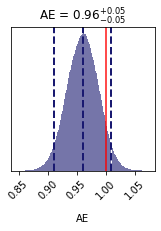

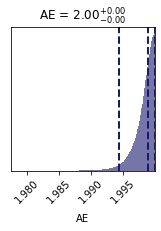

In [2]:
%%time

TARGET = 'E'
MODEL = 'acmb'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
Ecov = pp.covmat

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})

###

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

In [ ]:
%%time

TARGET = 'B'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
Bcov = pp.covmat

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})

###

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

In [ ]:
%%time

TARGET = 'EB'

datamap = {95:hp.smoothing(mapcmb,fwhm=FWHM[1],verbose=0)+nmap95[0],
           150:hp.smoothing(mapcmb,fwhm=FWHM[2],verbose=0)+nmap150[0]}
datanoise = {95:nmap95, 150:nmap150}
databeam = {95:FWHM[1], 150:FWHM[2]}
fidmap = {95:fidcmb,150:fidcmb}

pp = af.fitpipe(datamap,noises=datanoise,mask=mask,beams=databeam,
                fiducials=fidmap,
                targets=TARGET,background=MODEL)
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
EBcov = pp.covmat

pp.likelihood='gauss'
result_g = pp.analyse(kwargs={'nlive':400})

pp.likelihood='hl'
result_h = pp.analyse(kwargs={'nlive':400})

###

print (r'G $\chi^2_{min}$',-2*max(result_g['logl']))
print (r'HL $\chi^2_{min}$',-2*max(result_h['logl']))

fg, ax = dyplot.cornerplot(result_g,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)
fg, ax = dyplot.cornerplot(result_h,labels= pp.paramlist,quantiles=[0.025, 0.5, 0.975],truths=[1.,1.,0.05],
                           color='midnightblue',truth_color='red',show_titles=1,smooth=0.04)

end